In [26]:
import pcntoolkit as ptk
import pandas as pd
import numpy as np
import pprint
import arviz as az
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param

# Load data

In [27]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
fcon = pd.read_csv("resources/data/fcon1000.csv")

In [28]:
# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(name="full",
                                   dataframe=fcon,
                                   covariates=["age"],
                                   batch_effects=["sex","site"],
                                   response_vars=["WM-hypointensities","Left-Lateral-Ventricle", "rh_MeanThickness_thickness"])

display(normdata)

<xarray.NormData>
Dimensions:            (datapoints: 1078, covariates: 1, response_vars: 3,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_0' ... 'datapoint_1077'
  * response_vars      (response_vars) <U26 'WM-hypointensities' ... 'rh_Mean...
  * covariates         (covariates) <U3 'age'
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 25.63 18.34 ... 23.0
    y                  (datapoints, response_vars) float64 1.687e+03 ... 2.538
    batch_effects      (datapoints, batch_effect_dims) object 1 ... 'SaintLouis'
Attributes:
    name:                full
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'AnnArbor_a': 0, 'Ann...

## Filter out a couple of sites


<BarContainer object of 23 artists>

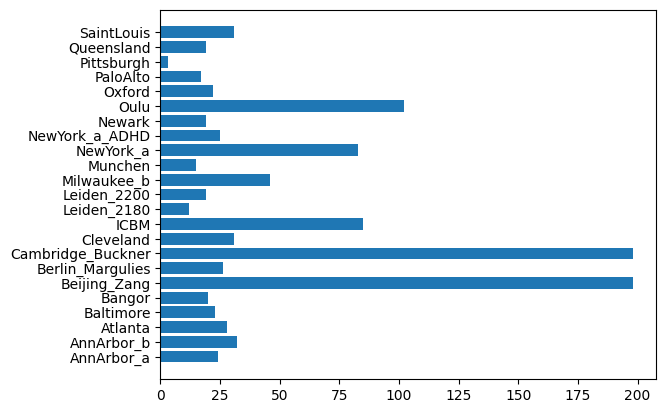

In [29]:
sites = normdata.batch_effects.sel(batch_effect_dims="site").values
unique_sites, counts = np.unique(sites, return_counts=True)
plt.barh(unique_sites, counts)

In [30]:
sites_to_model = ['Oulu','ICBM','Cambridge_Buckner','Beijing_Zang','NewYork_a']
sites_to_transfer_to = ['Milwaukee_b','SaintLouis']
transfer_data = normdata.select_batch_effects({'site':sites_to_transfer_to})
transfer_data.create_batch_effects_maps()
normdata = normdata.select_batch_effects({'site':sites_to_model})
normdata.create_batch_effects_maps()

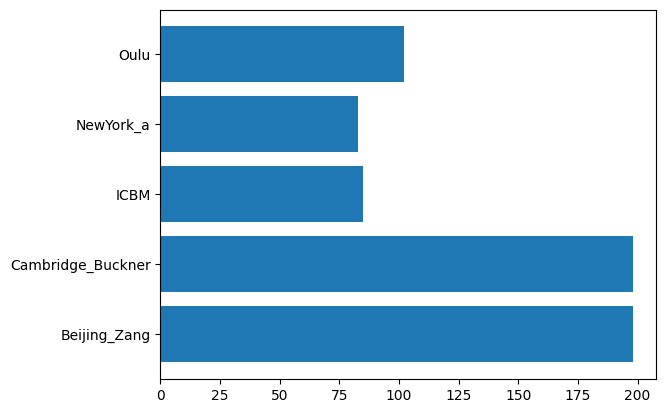

In [31]:

sites = normdata.batch_effects.sel(batch_effect_dims="site").values
unique_sites, counts = np.unique(sites, return_counts=True)
plt.barh(unique_sites, counts)
plt.show()

In [32]:
# Split data into training and test sets
# the splits are automatically stratified on the batch_effects
train, test = normdata.train_test_split(splits=[0.8, 0.2], split_names=["train", "test"])
display(train)
display(test)
transfer_train, transfer_test = transfer_data.train_test_split(splits=[0.8, 0.2], split_names=["transfer_train", "transfer_test"])


<xarray.NormData>
Dimensions:            (datapoints: 532, covariates: 1, response_vars: 3,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_830' ... 'datapoint_463'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'WM-hypointensities' ... 'rh_Mean...
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 49.16 22.0 ... 23.0 19.0
    y                  (datapoints, response_vars) float64 966.6 ... 2.521
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'Cambridg...
Attributes:
    name:                train
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

<xarray.NormData>
Dimensions:            (datapoints: 134, covariates: 1, response_vars: 3,
                        batch_effect_dims: 2)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
  * covariates         (covariates) <U3 'age'
  * response_vars      (response_vars) <U26 'WM-hypointensities' ... 'rh_Mean...
  * batch_effect_dims  (batch_effect_dims) <U4 'sex' 'site'
Data variables:
    X                  (datapoints, covariates) float64 19.0 21.0 ... 35.0 20.0
    y                  (datapoints, response_vars) float64 1.45e+03 ... 2.516
    batch_effects      (datapoints, batch_effect_dims) object 0 ... 'ICBM'
Attributes:
    name:                test
    batch_effects_maps:  {'sex': {0: 0, 1: 1}, 'site': {'Beijing_Zang': 0, 'C...

## Create some synthetic data

In [33]:
synth_data = normdata.create_synthetic_data(n_datapoints=200, range_dim='age')

## Configure the normative model

In [34]:
# Create a NormConf object
norm_conf = NormConf(savemodel=True, 
                    save_dir="resources/save_dir", 
                    log_dir="resources/log_dir",
                    inscaler="standardize",
                    outscaler="standardize",
                    basis_function="bspline",
                    order=3,
                    nknots=5)

Configuration of normative model is valid.


## Configure the regression model

In [35]:
# Configure mu
mu = Param(
    name="mu",
    linear=True,
    intercept=Param(name='intercept_mu',random=True)
)
# Configure sigma
sigma = Param(
    name="sigma",
    linear=True,
    mapping="softplus"
)
# Configure epsilon
epsilon = Param(
    name="epsilon",
    linear=False,
    dist_name="Normal",
    dist_params=(1,)
)
# Configure delta
delta=Param(
    name="delta",
    linear=False,
    dist_name="HalfNormal",
    dist_params=(1,)
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    cores=4,
    likelihood="SHASHb",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
)


Configuration of regression model is valid.


## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [36]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [37]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the norm_hbr model

In [22]:
norm_hbr.fit(train)

Going to fit 3 models
Fitting model for WM-hypointensities


KeyboardInterrupt: 

## Save the model

In [23]:
# The results are saved in the save_dir specified in the norm_conf
norm_hbr.save()
# del norm_hbr

Saving normative model to resources/save_dir/normative_model_dict.json


## Load the norm_hbr model from disk

In [38]:
norm_hbr = load_normative_model("resources/save_dir")

Loading normative model from resources/save_dir
Configuration of normative model is valid.
Configuration of regression model is valid.


## Predict using the norm_hbr model


In [39]:
results = norm_hbr.predict(test)

Going to predict 3 models
Predicting model for WM-hypointensities


Sampling: [y_pred]


Predicting model for Left-Lateral-Ventricle


Sampling: [y_pred]


Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities
Computing zscores for Left-Lateral-Ventricle
Computing zscores for rh_MeanThickness_thickness
Computing quantiles for WM-hypointensities
Computing quantiles for Left-Lateral-Ventricle
Computing quantiles for rh_MeanThickness_thickness


## Show the results


In [40]:
display(test.measures.to_dataframe())

measures
response_vars              statistics             
WM-hypointensities         Rho            0.432976
                           RMSE         502.090592
                           SMSE           1.041365
                           ExpV           0.173182
                           MSLL                NaN
                           BIC         1818.466225
Left-Lateral-Ventricle     Rho            0.212676
                           RMSE        4135.478527
                           SMSE           0.974249
                           ExpV           0.119040
                           MSLL                NaN
                           BIC         2383.565065
rh_MeanThickness_thickness Rho            0.400478
                           RMSE           0.071560
                           SMSE           0.780723
                           ExpV           0.219625
                           MSLL                NaN
                           BIC         -554.942930

In [41]:
display(test.zscores)

<xarray.DataArray 'zscores' (datapoints: 134, response_vars: 3)>
array([[ 1.31810702, -0.0127958 ,  1.61150912],
       [-0.38685887, -0.2886571 , -0.92629314],
       [ 1.57690658, -0.21955919, -1.64977074],
       [ 1.29188204,  0.57056979,  0.4503638 ],
       [ 1.96196754, -0.54970045,  0.56105586],
       [-1.15207687, -0.87957741, -0.48270203],
       [-1.13344997, -1.58648323, -1.01105073],
       [-0.98685037,  0.13489981, -0.51391714],
       [ 0.72680918, -0.09163684,  1.29596847],
       [ 0.60307077, -0.12890962, -0.86659289],
       [-0.29143376,  0.19659337, -1.35295383],
       [-0.19969098,  1.11966487, -0.54497864],
       [ 0.26354164,  1.75076891, -0.3114848 ],
       [-0.96215882,  0.75190928,  0.9189594 ],
       [ 1.12611991,  0.29346481, -0.377175  ],
       [ 1.08970939,  0.44131078,  0.69099504],
       [ 1.20063895, -1.87008862,  0.17529651],
       [-0.22030643,  1.24473243,  0.10576788],
       [-0.82849134, -0.01058766, -2.18079885],
       [-1.6829854 , -2.34938057,  0.80528784],
...
       [ 0.2220345 , -0.52036748,  0.23886979],
       [-0.14989679, -0.00499117,  0.41226216],
       [-0.63785263, -1.55850797,  0.65950482],
       [-1.82738122, -0.24128065,  1.06078891],
       [ 1.02105824, -1.02319431, -0.07783094],
       [-0.62360011, -2.23466542,  0.66166467],
       [ 0.61279737,  0.03560368, -1.29484305],
       [ 0.34871127, -2.19354164,  0.85938602],
       [ 0.36570454, -1.41712668, -1.052951  ],
       [ 0.36019717, -0.55151945,  1.85599713],
       [-1.47682219, -0.8251009 , -0.94533742],
       [ 0.9557537 ,  3.15355772, -0.21392314],
       [ 0.72996403, -0.4047086 ,  0.04408838],
       [ 0.75311009,  0.72662771,  0.25005017],
       [ 0.3912133 ,  0.79232255,  0.12988473],
       [ 1.16147765, -0.53310241,  1.76699701],
       [-0.67671456,  0.50728112,  1.37737104],
       [ 1.21471993, -1.01129555,  0.0210771 ],
       [ 0.93267861, -0.40907562, -2.32634643],
       [-1.02861205, -0.33224525, -1.4287186 ]])
Coordinates:
  * datapoints     (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
  * response_vars  (response_vars) <U26 'WM-hypointensities' ... 'rh_MeanThic...

In [42]:
test.batch_effects.sel(batch_effect_dims='site')

<xarray.DataArray 'batch_effects' (datapoints: 134)>
array(['Beijing_Zang', 'Cambridge_Buckner', 'Beijing_Zang',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'NewYork_a', 'Cambridge_Buckner', 'Beijing_Zang', 'NewYork_a',
       'ICBM', 'NewYork_a', 'Oulu', 'Oulu', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Oulu', 'Oulu', 'Oulu', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Beijing_Zang', 'NewYork_a',
       'NewYork_a', 'Beijing_Zang', 'Oulu', 'Oulu', 'Beijing_Zang',
       'ICBM', 'Oulu', 'Oulu', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'ICBM', 'NewYork_a', 'ICBM', 'Oulu', 'NewYork_a', 'Oulu',
       'NewYork_a', 'NewYork_a', 'ICBM', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'NewYork_a',
       'Cambridge_Buckner', 'Oulu', 'Oulu', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Cambridge_Buckner', 'ICBM',
       'Oulu', 'Beijing_Zang', 'ICBM', 'Beijing_Zang', 'NewYork_a',
       'Cambridge_Buckner', 'NewYork_a', 'NewYork_a', 'Cambridge_Buckner',
       'Beijing_Zang', 'Beijing_Zang', 'Beijing_Zang',
       'Cambridge_Buckner', 'Beijing_Zang', 'Oulu', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'NewYork_a', 'Beijing_Zang', 'ICBM', 'ICBM',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner',
       'Beijing_Zang', 'NewYork_a', 'Cambridge_Buckner', 'Beijing_Zang',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner',
       'Beijing_Zang', 'Beijing_Zang', 'ICBM', 'Cambridge_Buckner',
       'Beijing_Zang', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Beijing_Zang', 'Oulu', 'Cambridge_Buckner', 'Cambridge_Buckner',
       'Cambridge_Buckner', 'Beijing_Zang', 'Oulu', 'ICBM', 'Oulu',
       'Oulu', 'Beijing_Zang', 'ICBM', 'ICBM', 'Cambridge_Buckner',
       'ICBM', 'Cambridge_Buckner', 'Beijing_Zang', 'NewYork_a',
       'Cambridge_Buckner', 'Beijing_Zang', 'Beijing_Zang',
       'Beijing_Zang', 'Beijing_Zang', 'Cambridge_Buckner', 'Oulu',
       'Beijing_Zang', 'Beijing_Zang', 'NewYork_a', 'Cambridge_Buckner',
       'ICBM', 'ICBM', 'ICBM'], dtype=object)
Coordinates:
  * datapoints         (datapoints) <U14 'datapoint_212' ... 'datapoint_633'
    batch_effect_dims  <U4 'site'

In [43]:
norm_hbr.predict(synth_data)

Going to predict 3 models
Predicting model for WM-hypointensities


Sampling: [y_pred]


Predicting model for Left-Lateral-Ventricle


Sampling: [y_pred]


Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities
Computing zscores for Left-Lateral-Ventricle
Computing zscores for rh_MeanThickness_thickness
Computing quantiles for WM-hypointensities
Computing quantiles for Left-Lateral-Ventricle
Computing quantiles for rh_MeanThickness_thickness


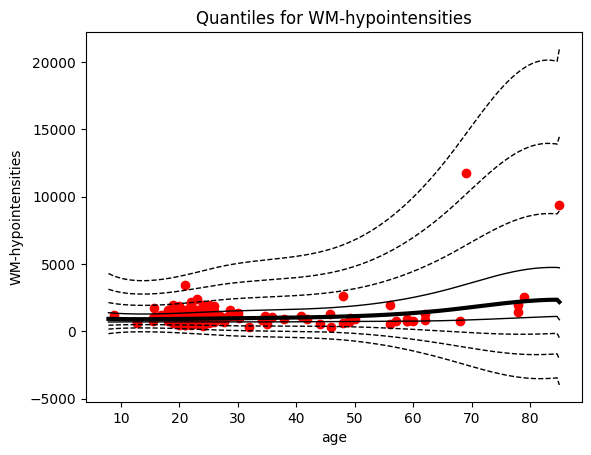

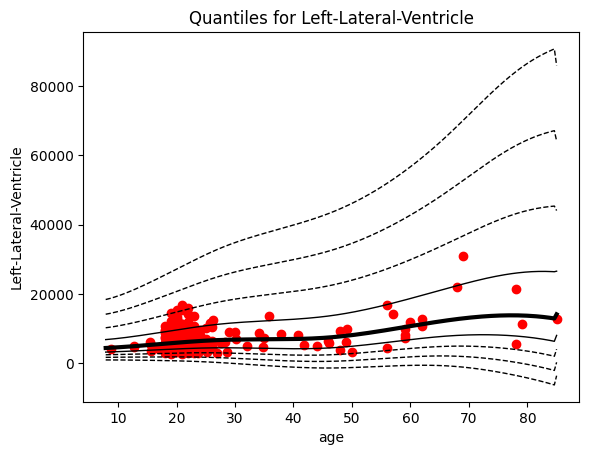

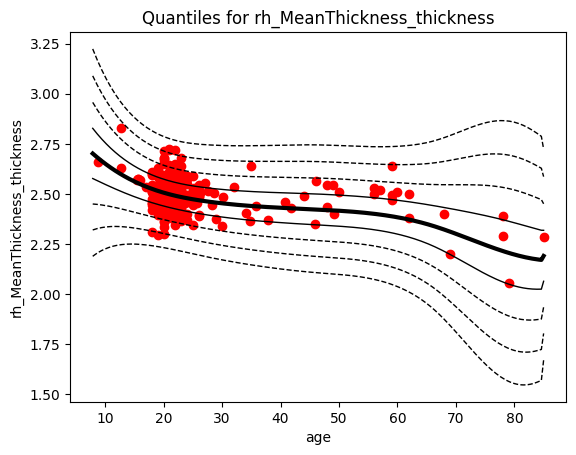

In [44]:
synth_data.plot_quantiles(show_data=True, scatter_data=train)

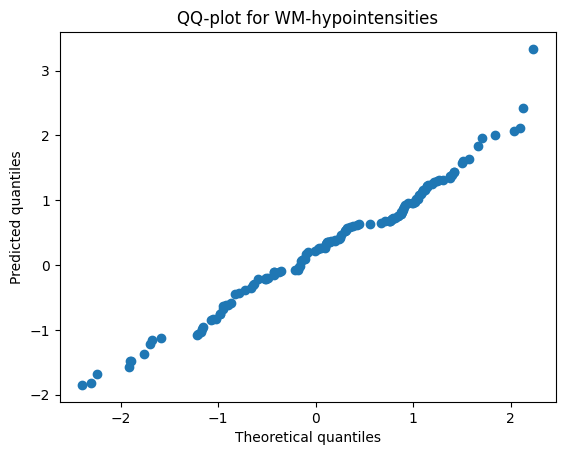

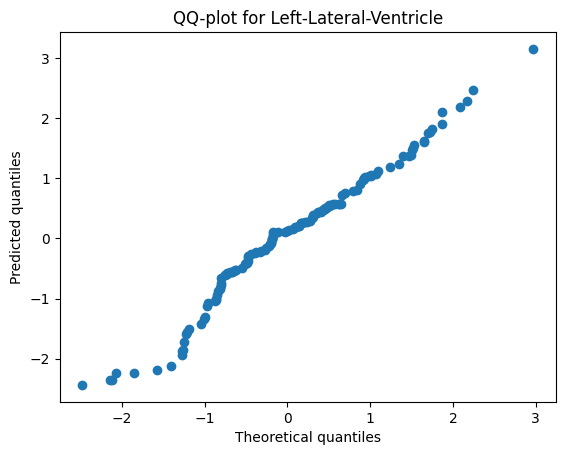

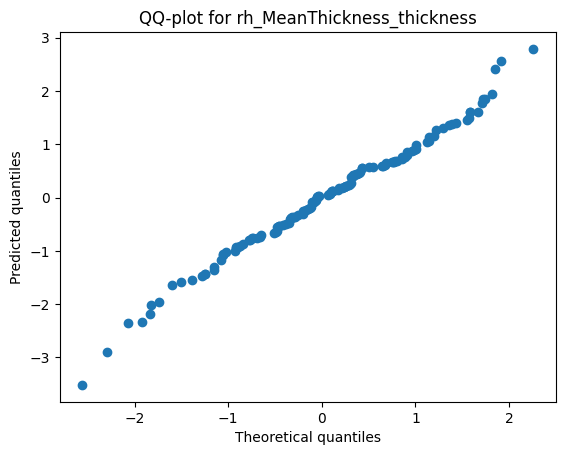

In [45]:
test.plot_qq()

In [46]:
transfered_model = norm_hbr.transfer(transfer_train)

Going to transfer 3 models
Transferring model for WM-hypointensities


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 210 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Transferring model for Left-Lateral-Ventricle


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 77 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Transferring model for rh_MeanThickness_thickness


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [slope_mu, mu_intercept_mu, sigma_intercept_mu, offset_intercept_mu, slope_sigma, intercept_sigma, epsilon, delta]


Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 93 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [53]:
object.__setattr__(transfered_model.norm_conf, 'save_dir', 'resources/transfer_save_dir')

In [54]:
transfered_model.save()

Saving normative model to resources/transfer_save_dir/normative_model_dict.json


In [47]:

transfered_model.predict(transfer_test)

TypeError: object of type 'NoneType' has no len()